## Debit Card - ATM Usage Analysis

#### It could be observed that there is no much difference in the usage of ATM Debit Card usage because of demonetization

### Imports, Constants, Parameter Settings

In [254]:
### Constants & Imports
import bs4
from bs4 import BeautifulSoup
import requests
import urllib
import urllib3
import re
import os
import wget
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
from dateutil.relativedelta import relativedelta
import numpy as np
#DATA_PATH = "/Users/apple/Gdrive/Term1/PRAT/ATMPOS/"
#OUT_PATH = "/Users/apple/Gdrive/Term1/PRAT/"
DATA_PATH='D:/iCloudDrive/ISB/Term1/PRAT/ATMPOS/'
DATA_TEMP_PATH='D:/TEMP/'
OUT_PATH='D:/iCloudDrive/ISB/Term1/PRAT/'
warnings.filterwarnings("ignore")


### Data Collection:
* Data Collection was performed in an **automated** fashion from RBI website (https://www.rbi.org.in/scripts/atmview.aspx) 
* Packages used: **requests**, **BeautifulSoup**, **wget** packages 
* Data was collected from **Apr 2011** till **Mar 2018**
* All the excel files were stored in a folder path
* Challenges faced:
    + Document format was XLS and XLSX, had to get the right format from the URL

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.79 Safari/537.36'}

for hdnYear in range(2011,2019):
        for hdnMonth in range(1,13):
            t = requests.post('https://www.rbi.org.in/scripts/atmview.aspx',
                        data={"__EVENTTARGET":"",  
                              "__EVENTARGUMENT": "",
                              "__VIEWSTATE": "/wEPDwUJNTk4NTg1MjM1ZGSKPLK6GXW82/ji/EAmldaxJ0hIqA==",
                              "__VIEWSTATEGENERATOR": "A2040FBE",
                              "__EVENTVALIDATION":"/wEdAAiBl8xNioCmqh1ImqhNQJtslK+XrsQEVyjeDxQ0A4GYXFBwzdjZXczwplb2HKGyLlqLrBfuDtX7nV3nL+5njT0xZDpy7WJnvc3tgXY08CYLJD+rfdwJAuBoVBISURIXWlx9xf1loRXvygROM/A1O+NHJounKCGGAHd04zzVhBPZz/vVliZA8zCb7qOGUcQWjLDx1Mqz",
                              "hdnYear": hdnYear,
                              "hdnMonth": hdnMonth
                        })
            t1 = BeautifulSoup(t.content.lower(),"lxml").find_all("a",href=re.compile(".XLS",re.IGNORECASE))
            for x in t1:
                url = x['href']
                url = url.replace('http://','https://')
                extn = url.split(".")
                f_name = os.path.join(str(DATA_TEMP_PATH),"ATM_POS" +"_" + str(hdnYear) + "_" + str(hdnMonth)+"."+str(extn[-1]))
                wget.download(url,f_name)


### Data Processing:
* An automated tool was developed to extract all the ATM/POS grand totals for Debit & Credit Cards from the excel documents
* All the collected data was stored in the form of dataframe & an output CSV file for further references
* Challenges faced:
    + Data format was not consistent for a few documents
        + Certain documents had multiple sheets
        + Additional text/legends were added
        + Data was not always starting at the same positions
        + Cells were merged in some docs, and it was not at some places
    + Few instances,where certain docs had multiple sheets - manually the excels (~3 documents) had to be manually cleansed. Otherwise the documents were automatically handled

In [255]:
os.chdir(DATA_PATH)
i=0
files = os.listdir()
df2 = pd.DataFrame(columns=['Date', 'pos_cc', 'atm_cc', 'pos_dc', 'atm_dc'])
for file_name in files:
    xl = pd.ExcelFile(file_name)
    sheet1=xl.sheet_names
    df1 = xl.parse(sheet1[0])
    if pd.isna(str(df1.iloc[0,0])) & pd.isna(str(df1.iloc[0,1])):
        df1.drop(df.index[0])
        print('Deleted')
    if pd.isna(str(df1.iloc[0,2])):
        x = 2
    else:
        x = 1
    if 'Amount' in str(df1.iloc[x,10]):
        tot_index = 2
        pos_cc = 11
        atm_cc = 10
        pos_dc = 16
        atm_dc = 15
    else:
        tot_index = 1
        pos_cc = 10
        atm_cc = 9
        pos_dc = 15
        atm_dc = 14
    for index, row in df1.iterrows():
        if 'Total' in str(df1.iloc[index,tot_index]):
            if df1.iloc[index,pos_cc]>0:
                month=file_name.split('_')[3].split('.')[0]
                year=file_name.split('_')[2]
                date1=datetime.date(year=int(year),month=int(month),day=int('01'))
                df2.loc[i] = [date1,df1.iloc[index,pos_cc],df1.iloc[index,atm_cc],df1.iloc[index,pos_dc],df1.iloc[index,atm_dc]]
    i=i+1
df2 = df2.sort_values(by='Date')
f_name= os.path.join(str(OUT_PATH),"Output.xlsx")
writer=pd.ExcelWriter(f_name,date_format='dd mm yyyy',options={'remove_timezone': True})
df2.to_excel(writer,"Sheet1")

### Visualizing the Data & Initial Analysis
* In this document, analysis of Debit Cards - ATM Transaction Volume was **only** performed

In [256]:
#df2.index.values
df3=df2[df2['Date'] < datetime.date(int('2016'),int('10'),int('30'))]
df3=df3.set_index(pd.DatetimeIndex(df3['Date']))
decomposition = seasonal_decompose(df3['atm_dc'],freq=12)  


### Decomposition of the trend
* As given in the problem statement, the forecasting value of the ATM Debit Card value, had demonetization NOT happened had to be found out
* Hence the model (seasonal decomposition, ARIMA model) for the period before decomposition would be performed

#### Data has been sub-setted till October to find the trend, seasonality, level 

* Prior to demonetization, there is a clear **linear** and **seasonality** trend
* Residuals do **NOT** have any trend which is good

In [257]:
df2.set_index(['Date'],inplace=True)

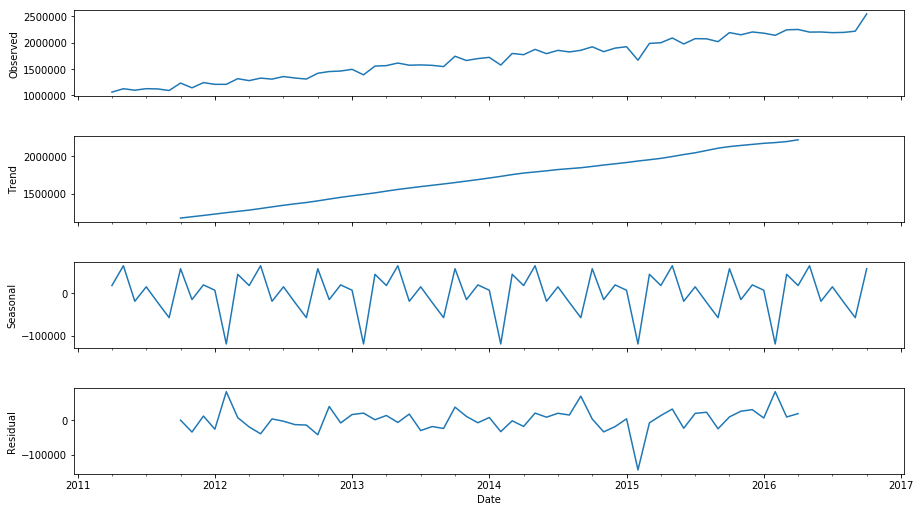

In [258]:
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

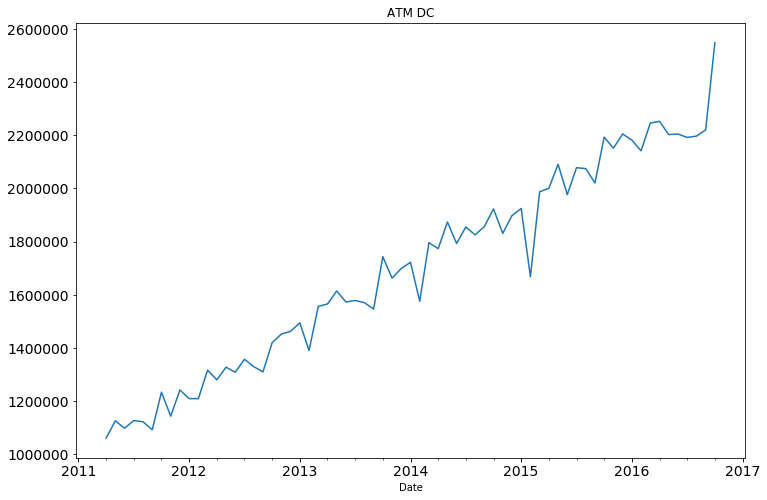

In [259]:
df3.atm_dc.plot(figsize=(12,8), title= 'ATM DC', fontsize=14)

#### ARIMA modelling
* To find the right (pdq) and seasonal (pdq) model triplets that fit the pre-demonetization trend
    + RMSE & AIC values was calculated for the various pdq,seasonal-pdq combinations
    + RMSE was the least in the combination **(pdq) = (1,1,0) seasonal-pdq = (1,1,1,12)**

> Credit: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
>
> Code was customized to include RMSE to find the best fitting (p,d,q) & seasonal (p,d,q) triplets

In [260]:
from sklearn.metrics import mean_squared_error
from math import sqrt

results_atm_dc = pd.DataFrame(columns=['pdq', 'seasonal_pdq', 'aic', 'rmse'])

index_rad=0

p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df3['atm_dc'],
                                            order=param,trend='n',
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            df3['forecast_atm_dc'] = results.predict(start='2015-10-01',dynamic=True)  
            rmse = sqrt(mean_squared_error(df3['2015-10-01':]['atm_dc'], df3['2015-10-01':]['forecast_atm_dc']))
            #df3[['atm_dc', 'forecast_atm_dc']].plot(figsize=(12, 8),title=str(param)+':'+str(param_seasonal)+':'+str(results.aic)) 
            print('ARIMA{}x{}12 - AIC:{} - RMSE:{}'.format(param, param_seasonal, results.aic,rmse))
            results_atm_dc.loc[index_rad] = [param,param_seasonal,results.aic,rmse]
            index_rad = index_rad+1
        except:
            print('Is this failing??')
            continue

Is this failing??
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1687.4705480806513 - RMSE:1492469.941304602
Is this failing??
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1156.4742269753199 - RMSE:280791.70739274356
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1401.1519227440665 - RMSE:114204.97264405685
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1370.779001681714 - RMSE:112829.66154776694
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1109.9336088185253 - RMSE:157006.09101523305
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1077.5502043578106 - RMSE:121991.20584092182
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1275104.0745236555 - RMSE:2227888.759201405
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1761.2717696419684 - RMSE:1714037.999202434
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1440.473224340373 - RMSE:295405.57296177436
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1114.3253166021007 - RMSE:276846.0689471872
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1847.4615770864007 - RMSE:290715.88813193096
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1757.977559105279 - RMSE:236118

In [261]:
results_atm_dc = results_atm_dc.sort_values('rmse')
results_atm_dc.head(5)

,pdq,seasonal_pdq,aic,rmse
51,"(1, 1, 0)","(1, 1, 1, 12)",1035.025604,84066.114200
59,"(1, 1, 1)","(1, 1, 1, 12)",1012.834102,84299.406082
58,"(1, 1, 1)","(1, 1, 0, 12)",1037.293842,88946.755402
50,"(1, 1, 0)","(1, 1, 0, 12)",1035.266930,88982.108634
27,"(0, 1, 1)","(1, 1, 1, 12)",1012.696836,89461.340983


In [272]:
mod = sm.tsa.statespace.SARIMAX(df3['atm_dc'],
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

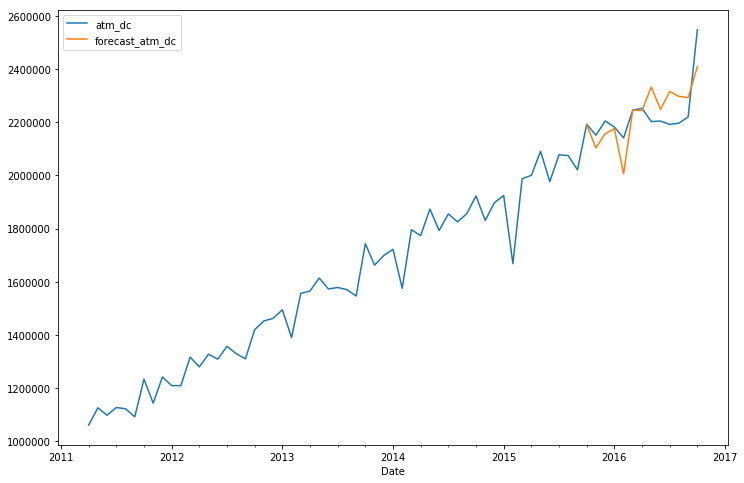

In [273]:
df3['forecast_atm_dc'] = results.predict(start='2015-10-01',end='2018-01-01',dynamic=True)  
df3[['atm_dc', 'forecast_atm_dc']].plot(figsize=(12, 8)) 

In [274]:
start = datetime.datetime.strptime("2016-10-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(1,18)]
future = pd.DataFrame(index=date_list, columns= df3.columns)
dates_list = [datex.date() for datex in date_list]
future['Date'] = dates_list
df4 = pd.concat([df3, future])

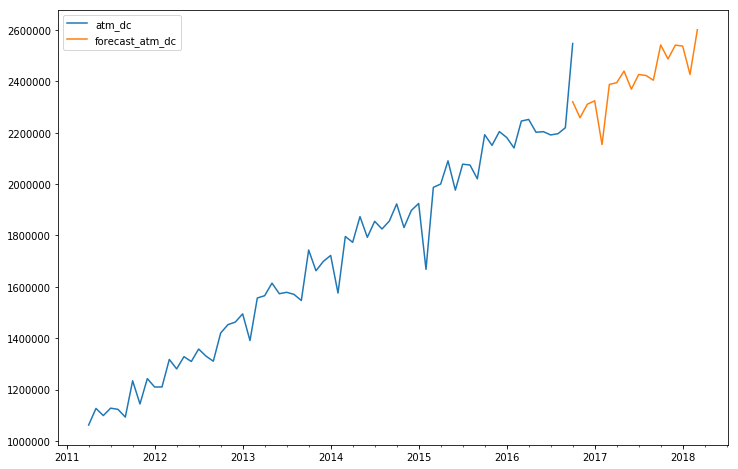

In [275]:
df4['forecast_atm_dc'] = results.predict(start = '2016-10-01', end = '2018-03-01', dynamic= True)  
df4[['atm_dc', 'forecast_atm_dc']].plot(figsize=(12, 8)) 

In [276]:
#df4.set_index(['Date'],inplace=True)
for index, row in df4.iterrows():
    #print(df4.loc[index,'forecast_atm_dc'])
    if np.isnan(df4.loc[index,'forecast_atm_dc']):
        df4.loc[index,'forecast_atm_dc'] = df4.loc[index,'atm_dc']

In [277]:
dfx=df2
#dfx.set_index(['Date'],inplace=True)

In [278]:
merge=pd.merge(df2,df4, how='inner', left_index=True, right_index=True)

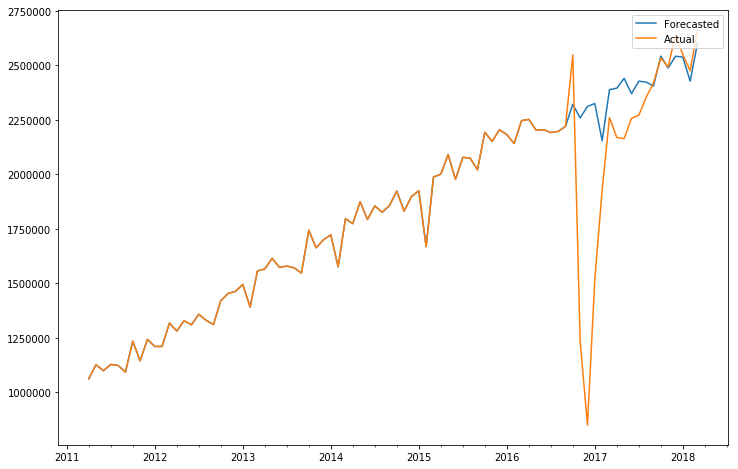

In [279]:

merge['forecast_atm_dc'].plot(figsize=(12, 8),label='Forecasted') 
merge['atm_dc_x'].plot(figsize=(12, 8),label='Actual') 
plt.legend(loc='upper right')
plt.show()


In [288]:
merge['diff'] = merge['atm_dc_x'] - merge['forecast_atm_dc']
merge[merge['diff']!=0]['diff'].apply(lambda x: '%f' % x)

2016-10-01      226665.856623
2016-11-01    -1024237.722071
2016-12-01    -1462067.573233
2017-01-01     -808123.933280
2017-02-01     -225730.888810
2017-03-01     -128949.115007
2017-04-01     -226573.831953
2017-05-01     -276460.741745
2017-06-01     -113039.879839
2017-07-01     -156452.394331
2017-08-01      -70183.943564
2017-09-01       14591.594006
2017-10-01       -9019.314158
2017-11-01        5178.328270
2017-12-01       98728.651305
2018-01-01       12561.937209
2018-02-01       47591.823002
2018-03-01       61806.328961
Name: diff, dtype: object